In [113]:
# %pip install lightfm
# %pip install --upgrade pandas==1.4.4
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
import pandas as pd 
from sklearn.model_selection import train_test_split
from scipy import sparse as spr
from scipy.sparse import csr_matrix
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import os
import pickle
# %matplotlib inline

In [132]:
path2Keep= r"data2Keep\\" # path to load data
# load the data
onDrive= False
if onDrive == True:
    path= "/content/drive/MyDrive/School/IDC/RS/Project/data/"
    path2Keep= path.replace("/data", "") +  r"data2Keep/" # path to save the data to
    from google.colab import drive
    drive.mount('/content/drive')
else:
    path= r"data\\"
    path2Keep= r"data2Keep"

# load the beforelastXRatings.pkl into a dataframe
b4Ratings_df= pd.read_pickle(path2Keep+ r"\beforelastXRatings.pkl", compression= "gzip")
b4Ratings_df["movieId"]= b4Ratings_df["movieId"].fillna(0).astype(int)
print(f'shape of b4Ratings_df: {b4Ratings_df.shape}')
# load the lastXRatings.pkl into a dataframe
lastRatings_df= pd.read_pickle(path2Keep+ r"\lastXRatings.pkl", compression= "gzip")
lastRatings_df["movieId"]= lastRatings_df["movieId"].fillna(0).astype(int)
print(f'shape of lastRatings_df: {lastRatings_df.shape}')
# combine the two dataframes
ratings_df= pd.concat([b4Ratings_df, lastRatings_df], axis=0)
print(f'shape of ratings_df: {ratings_df.shape}')
# load the movies_df.pkl into a dataframe
movies_df= pd.read_pickle(path2Keep+ r"\movies_df.pkl", compression= "gzip")
movies_df['movieId']= movies_df['movieId'].astype(int)
movies_df['original_title']= movies_df['original_title'].fillna('')
print(f'shape of movies_df: {movies_df.shape}')

shape of b4Ratings_df: (23002740, 4)
shape of lastRatings_df: (383772, 4)
shape of ratings_df: (23386512, 4)
shape of movies_df: (9903, 4907)


In [90]:
# #  for the BPR1 model, we ned to use all ratings, but only those made by the train users
# #  read the train_users_df as pickle from path2Keep
# train_users_df= pd.read_pickle(path2Keep+ r"\train_users.pkl").to_frame()
# train_users_df= train_users_df.reset_index().rename(columns= {'index': 'userId'})
# test_user_df= pd.read_pickle(path2Keep+ r"\test_users.pkl").to_frame()
# test_user_df= test_user_df.reset_index().rename(columns= {'index': 'userId'})
# #  merge the train_users_df with the ratings_df
# BPR1TrainRatings_df= pd.merge(ratings_df, train_users_df, on= 'userId', how= 'inner')
# BPR1TestRatings_df= pd.merge(ratings_df, test_user_df, on= 'userId', how= 'inner')
# print(f'shape of ratings_df: {ratings_df.shape}')
# print(f'shape of BPR1ratings_df: {BPR1TrainRatings_df.shape}')

shape of ratings_df: (20222526, 4)
shape of BPR1ratings_df: (16171550, 5)


In [120]:
print(f'number of unique movies in b4Ratings_df= {b4Ratings_df["movieId"].nunique()}')
print(f'number of unique movies in b4Ratings_df= {movies_df["movieId"].nunique()}')
print(f'number of unique users in movies_df= {b4Ratings_df["userId"].nunique()}')

number of unique movies in b4Ratings_df= 9903
number of unique movies in b4Ratings_df= 9903
number of unique users in b4Ratings_df= 127924


### BPR1 model should be on all ratings up to last 3

In [121]:
#  create a sparse matrix from the dataframe using the csr_matrix function
BPR1csrMatrixTrain = spr.csr_matrix((b4Ratings_df["rating"] ,(b4Ratings_df["userId"], b4Ratings_df["movieId"])), shape=(ratings_df["userId"].max()+1, ratings_df["movieId"].max()+1))
print(f' shape of csrMatrixTrain.shape {BPR1csrMatrixTrain.shape}')

 shape of csrMatrixTrain.shape (270897, 174056)


In [122]:
# The BPR models (for both movies and apps) were trained for 100 epochs with a target dimension n = 25
#  check if the model is already at path2Keep+"bprModel.pkl"
print(path2Keep)
if os.path.exists(path2Keep+"BPR1Model.pkl"):
    print("model already exists")
    with open(path2Keep+"BPR1Model.pkl", "rb") as f:
        modelBPR1 = pickle.load(f)
else:
    modelBPR1 = LightFM(learning_rate=0.01, loss='bpr', no_components=25)
    modelBPR1.fit(BPR1csrMatrixTrain, epochs=100, verbose=True, num_threads=8)
    #  drop the model from memory into file
    with open(path2Keep+"BPR1Model.pkl", "wb") as f:
        pickle.dump(modelBPR1, f, protocol=pickle.HIGHEST_PROTOCOL)
    #  get model's embeddings
    BPR1_item_embeddings = modelBPR1.get_item_representations()[1]
    BPR1_user_embeddings = modelBPR1.get_user_representations()[1]
    print(f'item_embeddings.shape: {BPR1_item_embeddings.shape}')
    print(f'user_embeddings.shape: {BPR1_user_embeddings.shape}')
    #  drop the embeddings from memory into file
    with open(path2Keep+"BPR1_item_embeddings.pkl", "wb") as f:
        pickle.dump(BPR1_item_embeddings, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(path2Keep+"BPR1_user_embeddings.pkl", "wb") as f:
        pickle.dump(BPR1_user_embeddings, f, protocol=pickle.HIGHEST_PROTOCOL)


data2Keep


Epoch: 100%|██████████| 5/5 [08:05<00:00, 97.09s/it] 

item_embeddings.shape: (174056, 25)
user_embeddings.shape: (270897, 25)


       movieId                                original_title  release_date
255        260                                     Star Wars  2.333664e+08
2514      2628     Star Wars: Episode I - The Phantom Menace  9.270720e+08
5267      5378  Star Wars: Episode II - Attack of the Clones  1.021421e+09
10121    33493  Star Wars: Episode III - Revenge of the Sith  1.116288e+09
12953    61160                     Star Wars: The Clone Wars  1.217894e+09
26471   122886                  Star Wars: The Force Awakens  1.450138e+09


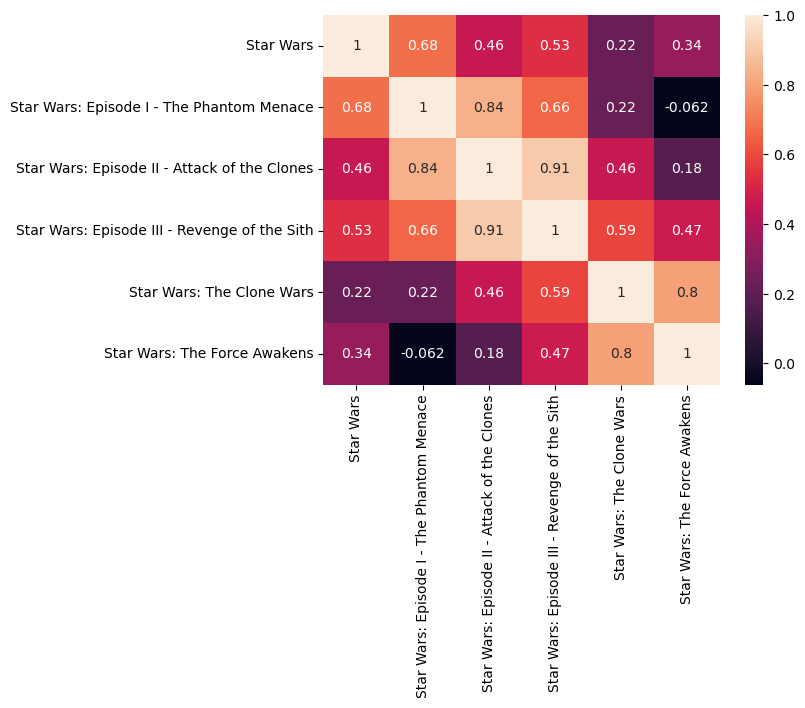

In [124]:
# get all star wars movies
movies_df['original_title']= movies_df['original_title'].fillna('')
starWars_df= movies_df[movies_df['original_title'].str[: 9] ==('Star Wars')]
print(starWars_df[['movieId','original_title','release_date']])
# get the movieId's of the star wars movies
starWarsMovieIds= starWars_df['movieId'].to_list()
# get the embeddings of the star wars movies
starWarsEmbeddings= BPR1_item_embeddings[starWarsMovieIds]
# #  get the cosine similarity of the star wars movies
starWarsCosineSim= cosine_similarity(starWarsEmbeddings)
#  create a heatmap of the cosine similarity
sns.heatmap(starWarsCosineSim, annot=True, xticklabels= starWars_df['original_title'], yticklabels= starWars_df['original_title'])
plt.show()

In [125]:
#  get the 10 most similar items to 122886 Star Wars: The Force Awakens
movieID= 122886
topX= 5
movie1Embedding= BPR1_item_embeddings[movieID]
movie1CosineSim= cosine_similarity(movie1Embedding.reshape(1, -1), BPR1_item_embeddings)
movie1CosineSim= movie1CosineSim.reshape(-1)
movie1CosineSim= pd.DataFrame(movie1CosineSim, columns= ['cosineSim'])
# movie1CosineSim['movieId']= movies_df['movieId']
movie1CosineSim= movie1CosineSim.sort_values(by= 'cosineSim', ascending= False)
#  merge the movie1CosineSim with the movies_df
movie1CosineSim= pd.merge(movie1CosineSim, movies_df, left_index=True, right_on="movieId", how= 'inner')
#  get the topX most similar movies
movie1CosineSim.iloc[1: topX+1].head(topX)


,cosineSim,id,imdb_id,original_title,overview,release_date,runtime,title,movieId,imdbId,...,tl,tr,uk,ur,uz,vi,wo,xx,zh,zu
23714,0.990037,118340.0,tt2015381,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",1.406678e+09,121.0,Guardians of the Galaxy,112852,2015381.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17888,0.985347,24428.0,tt0848228,The Avengers,When an unexpected enemy emerges and threatens...,1.335312e+09,143.0,The Avengers,89745,848228.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20943,0.977944,54138.0,tt1408101,Star Trek Into Darkness,When the crew of the Enterprise is called back...,1.367712e+09,132.0,Star Trek Into Darkness,102445,1408101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40835,0.976473,330459.0,tt3748528,Rogue One: A Star Wars Story,A rogue band of resistance fighters unite for ...,1.481674e+09,133.0,Rogue One: A Star Wars Story,166528,3748528.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20015,0.972035,49051.0,tt0903624,The Hobbit: An Unexpected Journey,"Bilbo Baggins, a hobbit enjoying his quiet lif...",1.353888e+09,169.0,The Hobbit: An Unexpected Journey,98809,903624.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### BPR2 model is on train items only and before last X ratings

In [128]:
#  for the BPR2 model, we ned to use all ratings, but only those made on the train items
#  read the train_items_df as pickle from path2Keep
train_items_df= pd.read_pickle(path2Keep+ r"train_movies.pkl").to_frame()
train_items_df= train_items_df.reset_index().rename(columns= {'index': 'movieId'})
#  merge the train_items_df with the ratings_df
BPR2TrainRatings_df= pd.merge(b4Ratings_df, train_items_df, on= 'movieId', how= 'inner')
print(f'shape of ratings_df: {ratings_df.shape}')
print(f'shape of BPR2TrainRatings_df: {BPR2TrainRatings_df.shape}')
print(f'number of unique movies in b4Ratings_df= {b4Ratings_df["movieId"].nunique()}')
print(f'number of unique movies in BPR2TrainRatings_df= {BPR2TrainRatings_df["movieId"].nunique()}')


shape of ratings_df: (23386512, 4)
shape of BPR2TrainRatings_df: (20304384, 5)
 number of unique movies in b4Ratings_df= 9903
 number of unique movies in BPR2TrainRatings_df= 8912


In [129]:
#  create a sparse matrix from the dataframe using the csr_matrix function
BPR2csrMatrixTrain = spr.csr_matrix((BPR2TrainRatings_df["rating"] ,(BPR2TrainRatings_df["userId"], BPR2TrainRatings_df["movieId"])), shape=(ratings_df["userId"].max()+1, ratings_df["movieId"].max()+1))
print(f' shape of csrMatrixTrain.shape {BPR2csrMatrixTrain.shape}')

 shape of csrMatrixTrain.shape (270897, 174056)


In [130]:
# The BPR models (for both movies and apps) were trained for 100 epochs with a target dimension n = 25
#  check if the model is already at path2Keep+"bprModel.pkl"
print(path2Keep)
if os.path.exists(path2Keep+"BPR2Model.pkl"):
    print("model already exists")
    with open(path2Keep+"BPR2Model.pkl", "rb") as f:
        modelBPR2 = pickle.load(f)
else:
    modelBPR2 = LightFM(learning_rate=0.02, loss='bpr', no_components=25)
    modelBPR2.fit(BPR2csrMatrixTrain, epochs=100, verbose=True, num_threads=8)
    #  drop the model from memory into file
    with open(path2Keep+"BPR2Model.pkl", "wb") as f:
        pickle.dump(modelBPR2, f, protocol=pickle.HIGHEST_PROTOCOL)
    #  get model's embeddings
    BPR2_item_embeddings = modelBPR2.get_item_representations()[1]
    BPR2_user_embeddings = modelBPR2.get_user_representations()[1]
    print(f'item_embeddings.shape: {BPR2_item_embeddings.shape}')
    print(f'user_embeddings.shape: {BPR2_user_embeddings.shape}')
    #  drop the embeddings from memory into file
    with open(path2Keep+"\BPR2_item_embeddings.pkl", "wb") as f:
        pickle.dump(BPR2_item_embeddings, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(path2Keep+"\BPR2_user_embeddings.pkl", "wb") as f:
        pickle.dump(BPR2_user_embeddings, f, protocol=pickle.HIGHEST_PROTOCOL)

data2Keep


Epoch: 100%|██████████| 5/5 [10:22<00:00, 124.41s/it]

item_embeddings.shape: (174056, 25)
user_embeddings.shape: (270897, 25)


       movieId                                original_title  release_date
255        260                                     Star Wars  2.333664e+08
2514      2628     Star Wars: Episode I - The Phantom Menace  9.270720e+08
5267      5378  Star Wars: Episode II - Attack of the Clones  1.021421e+09
10121    33493  Star Wars: Episode III - Revenge of the Sith  1.116288e+09
12953    61160                     Star Wars: The Clone Wars  1.217894e+09
26471   122886                  Star Wars: The Force Awakens  1.450138e+09


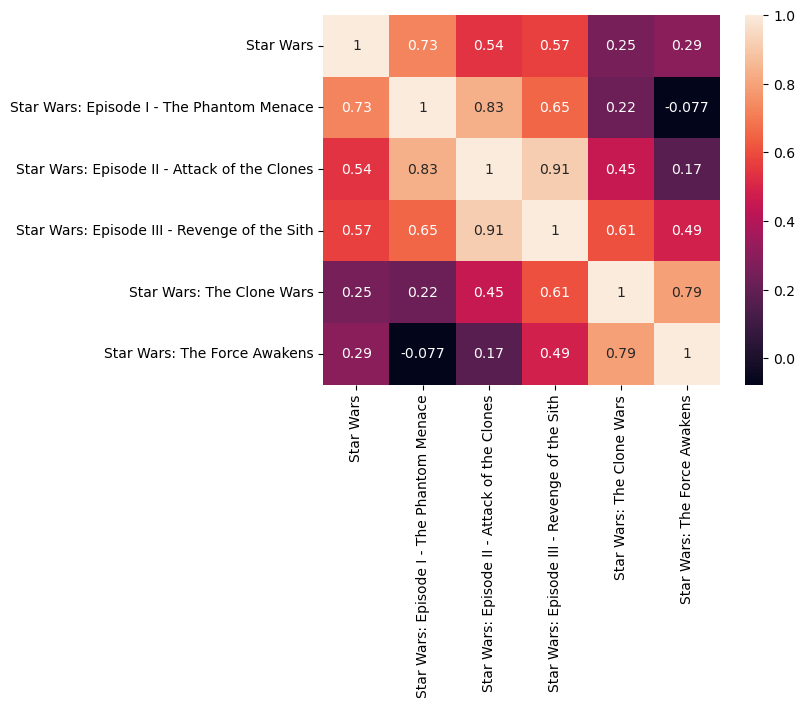

In [131]:
# get all star wars movies
starWars_df= movies_df[movies_df['original_title'].str[: 9] ==('Star Wars')]
print(starWars_df[['movieId','original_title','release_date']])
# get the movieId's of the star wars movies
starWarsMovieIds= starWars_df['movieId'].to_list()
# get the embeddings of the star wars movies
starWarsEmbeddings= BPR2_item_embeddings[starWarsMovieIds]
# #  get the cosine similarity of the star wars movies
starWarsCosineSim= cosine_similarity(starWarsEmbeddings)
#  create a heatmap of the cosine similarity
sns.heatmap(starWarsCosineSim, annot=True, xticklabels= starWars_df['original_title'], yticklabels= starWars_df['original_title'])
plt.show()